In [31]:
import sys
import os
import torch
import numpy as np
from ast_models import ASTModel

In [32]:
# Initialize model with the following arguments: fshape: 128, tshape: 2, fstride: 128, tstride: 2, input_fdim: 128, input_tdim: 998, model_size: base
# audio_model = ASTModel(fshape=args.fshape, tshape=args.tshape, fstride=args.fshape, tstride=args.tshape, input_fdim=args.num_mel_bins, input_tdim=args.target_length, model_size=args.model_size, pretrain_stage=True)

model1 = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)
model2 = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)
model5 = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)
model20 = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)
model50 = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)

pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499


In [33]:
model1 = torch.nn.DataParallel(model1)
model2 = torch.nn.DataParallel(model2)
model5 = torch.nn.DataParallel(model5)
model20 = torch.nn.DataParallel(model20)
model50 = torch.nn.DataParallel(model50)
model1.load_state_dict(torch.load('/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240416-103133/models/audio_model.1.pth'))
model2.load_state_dict(torch.load('/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240416-103133/models/audio_model.2.pth'))
model5.load_state_dict(torch.load('/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240416-103133/models/audio_model.5.pth'))
model20.load_state_dict(torch.load('/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240416-103133/models/audio_model.20.pth'))
model50.load_state_dict(torch.load('/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240416-103133/models/audio_model.40.pth'))

<All keys matched successfully>

In [34]:
#model.eval()

In [35]:
# Assume `test_input` is your preprocessed input tensor shaped appropriately for your model
test_input = torch.randn(size=(1, 128, 1024))  # Example shape: (batch_size, channels, freq_bins, time_frames)
print(test_input.shape)
print(test_input[0])

# print maximum and minimum value of input
print(torch.max(test_input))
print(torch.min(test_input))


# Assuming 'model' originally wrapped by DataParallel
# Remove DataParallel wrapper and move to CPU
model1 = model1.module  # Access the original model to remove the DataParallel wrapper
model2 = model2.module 
model5 = model5.module
model20 = model20.module
model50 = model50.module
model1.to('cpu')
model2.to('cpu')
model5.to('cpu')
model20.to('cpu')
model50.to('cpu')

# Verify that the model is now on CPU
print(next(model1.parameters()).device)  # Should print 'cpu'

# check device of input
print(test_input.device)

torch.Size([1, 128, 1024])
tensor([[ 1.1888,  0.7800, -0.4163,  ...,  0.3760, -0.9472,  0.0491],
        [ 0.0333,  0.4443, -1.1583,  ..., -1.7805, -0.1347,  0.2679],
        [-0.1966, -2.0870, -2.2051,  ...,  0.2537, -0.6702, -0.7810],
        ...,
        [-0.8826,  0.8971,  0.1580,  ..., -1.7398,  0.4775,  0.1984],
        [ 0.3440, -1.0503, -1.1578,  ..., -1.3989,  0.5996, -0.6092],
        [-0.9419,  0.8488,  1.2483,  ...,  0.1876,  2.1487, -0.9700]])
tensor(4.2727)
tensor(-4.3621)
cpu
cpu


In [36]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch

# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Print information about the audio
print("Time of last sample:", time[-1])
print("Number of samples:", len(audio_signal))
print("Sample rate:", sample_rate)
print("Duration of audio:", len(audio_signal) / sample_rate)
print("Shape of audio signal:", audio_signal.shape)
print("Type of audio signal:", type(audio_signal))
print("Data type of audio signal:", audio_signal.dtype)


# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)
print("Type of audio tensor:", type(audio_tensor))
print("Data type of audio tensor:", audio_tensor.dtype)
print("Shape of audio tensor:", audio_tensor.shape)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()
print("Data type of audio tensor:", audio_tensor.dtype)

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)
print("Shape of audio tensor:", audio_tensor.shape)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
print(f"Shape of fbank features: {fbank_features.shape}")
test_input = fbank_features

# normalize fbank features
dataset_mean=-3.6925695
dataset_std=4.020388
test_input = (test_input - dataset_mean) / (2 * dataset_std)

# add batch dimension
test_input = test_input.unsqueeze(0)
print(f"Shape of fbank features: {test_input.shape}")

Time of last sample: 9.9999375
Number of samples: 160000
Sample rate: 16000
Duration of audio: 10.0
Shape of audio signal: (160000,)
Type of audio signal: <class 'numpy.ndarray'>
Data type of audio signal: float64
Type of audio tensor: <class 'torch.Tensor'>
Data type of audio tensor: torch.float64
Shape of audio tensor: torch.Size([160000])
Data type of audio tensor: torch.float32
Shape of audio tensor: torch.Size([1, 160000])
Shape of fbank features: torch.Size([998, 128])
Shape of fbank features: torch.Size([1, 998, 128])


In [37]:
# test model on 40 masked frames (2x128=256)
with torch.no_grad():
    pred1, target1 = model1(test_input, task='visualize_mask', cluster=False, mask_patch=40)
    pred2, target2 = model2(test_input, task='visualize_mask', cluster=False, mask_patch=40)
    pred5, target5 = model5(test_input, task='visualize_mask', cluster=False, mask_patch=40)
    pred20, target20 = model20(test_input, task='visualize_mask', cluster=False, mask_patch=40)
    pred50, target50 = model50(test_input, task='visualize_mask', cluster=False, mask_patch=40)

input shape:  torch.Size([1, 1, 128, 998])
mask_patch:  40
cluster:  False
show_mask:  True
self.v.patch_embed(input) shape:  torch.Size([1, 499, 768])
unfolded input shape (after transposing dimensions 1 and 2):  torch.Size([1, 499, 256])
mask_index shape:  torch.Size([1, 40])
mask_dense shape:  torch.Size([1, 499, 768])
num_patches:  499 mask_patch:  40
mask_index shape:  torch.Size([40])
mask_embed shape:  torch.Size([1, 1, 768])
mask_tokens shape:  torch.Size([1, 499, 768])
x shape after masking:  torch.Size([1, 499, 768])
x shape after concatenating cls_tokens and dist_token:  torch.Size([1, 501, 768])
x shape after transformer layers:  torch.Size([1, 501, 768])
input shape:  torch.Size([1, 1, 128, 998])
mask_patch:  40
cluster:  False
show_mask:  True
self.v.patch_embed(input) shape:  torch.Size([1, 499, 768])
unfolded input shape (after transposing dimensions 1 and 2):  torch.Size([1, 499, 256])
mask_index shape:  torch.Size([1, 40])
mask_dense shape:  torch.Size([1, 499, 768])


torch.Size([1, 40, 256])
torch.Size([1, 40, 256])


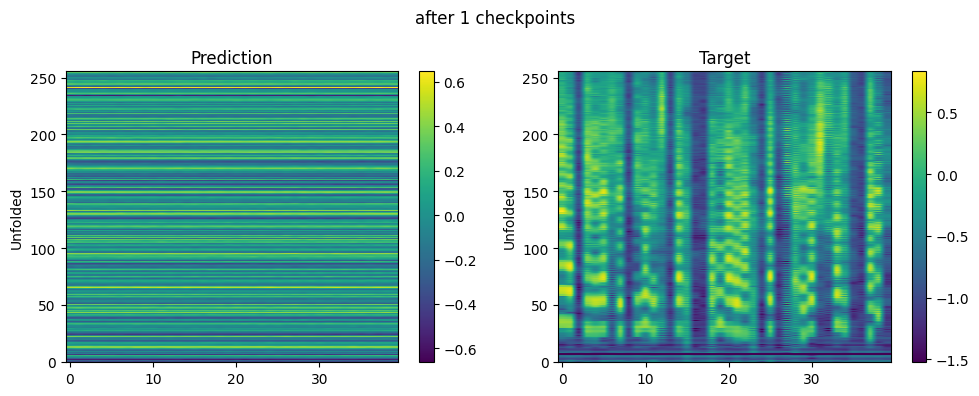

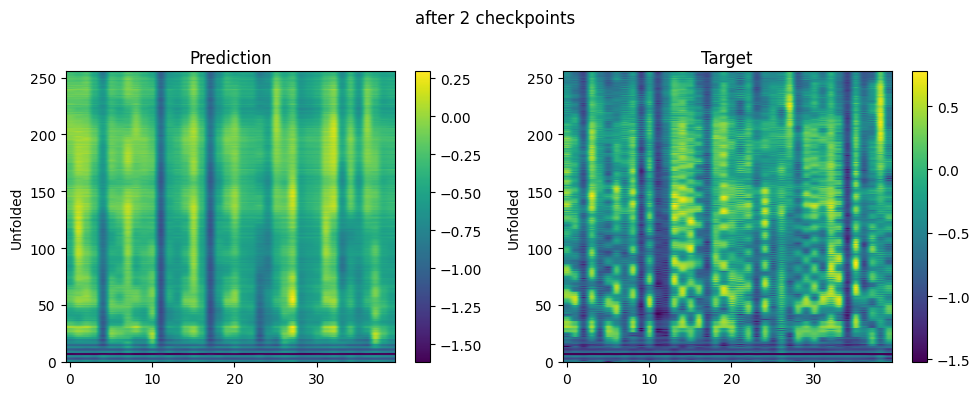

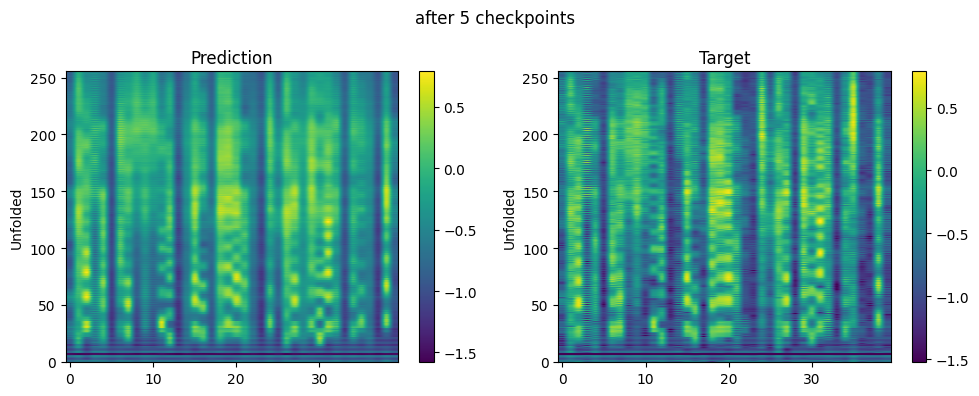

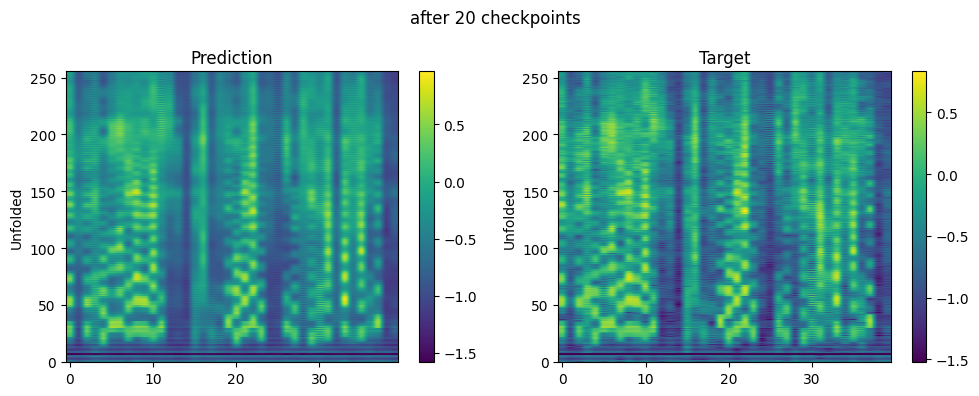

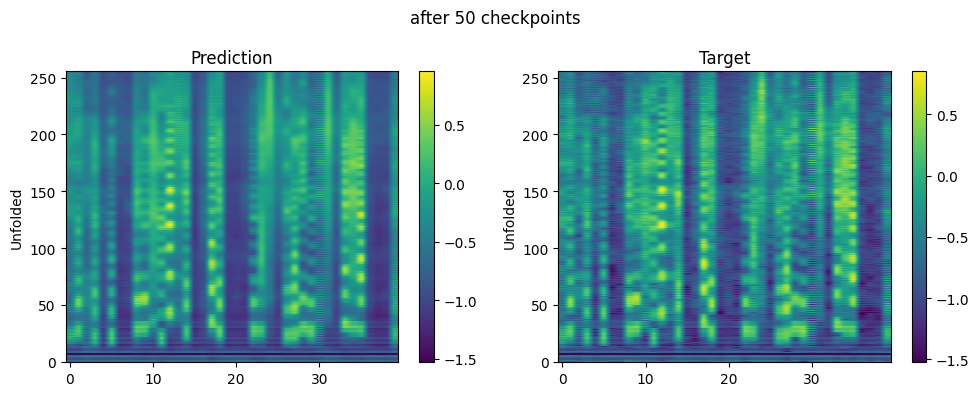

In [38]:
def show_target_and_prediction(i, pred, target):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # set title
    fig.suptitle(f"after {i} checkpoints")

    # Visualize the prediction
    im1 = axes[0].imshow(pred.squeeze().cpu().numpy().T, aspect='auto', origin='lower', cmap='viridis')
    axes[0].set_title("Prediction")
    #axes[0].set_xlabel("Time Frames")
    axes[0].set_ylabel("Unfolded")
    fig.colorbar(im1, ax=axes[0])

    # Visualize the target
    im2 = axes[1].imshow(target.squeeze().cpu().numpy().T, aspect='auto', origin='lower', cmap='viridis')
    axes[1].set_title("Target")
    #axes[1].set_xlabel("Time Frames")
    axes[1].set_ylabel("Unfolded")
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

print(pred1.shape)
print(target1.shape)

show_target_and_prediction(1, pred1, target1)
show_target_and_prediction(2, pred2, target2)
show_target_and_prediction(5, pred5, target5)
show_target_and_prediction(20, pred20, target20)
show_target_and_prediction(50, pred50, target50)